# FED rate

## load tha data

In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, genpareto

# Load dataset
df = pd.read_csv('silver.csv')

# Choose the desired date range
#df = df[(df['Date'] >= '1985-01-01') ]

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Handle missing values (forward-fill method)
df['USD'] = df['USD'].ffill()


## Handle missing values

In [409]:
df['rate_change'] = df['USD'].pct_change()
df = df.dropna()


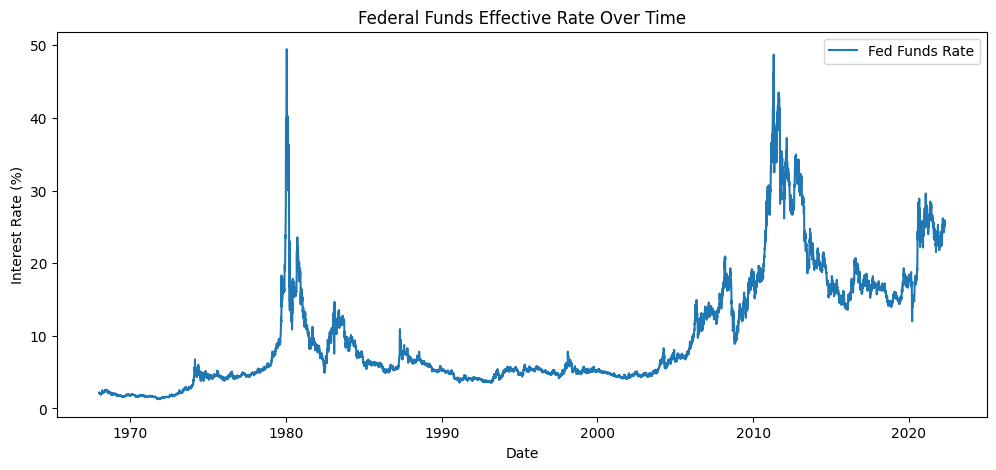

In [410]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['USD'], label='Fed Funds Rate')
plt.title('Federal Funds Effective Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()


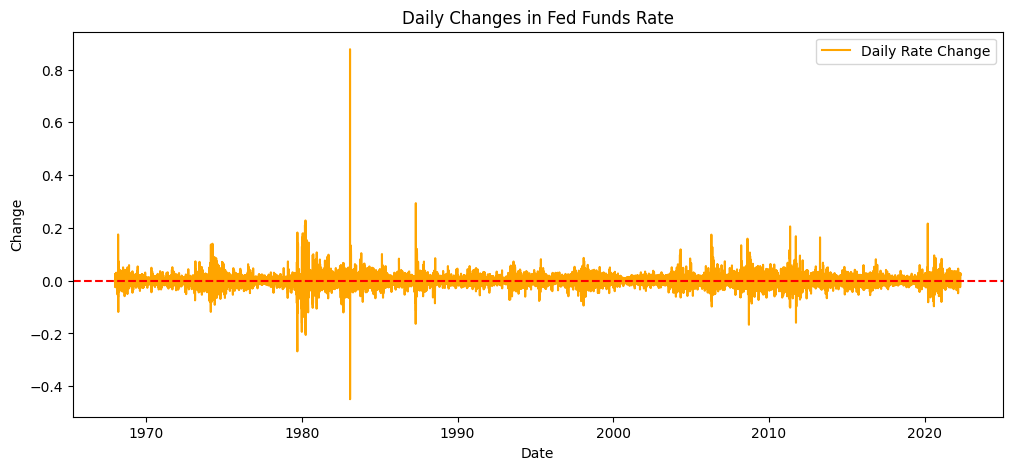

In [411]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['rate_change'], label='Daily Rate Change', color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Daily Changes in Fed Funds Rate')
plt.xlabel('Date')
plt.ylabel('Change')
plt.legend()
plt.show()


In [412]:
# Block Maxima Method for hikes (positive changes)
df['year_month'] = df['Date'].dt.to_period('M')
block_maxima_hikes = df.groupby('year_month')['rate_change'].max()

# Block Minima Method for cuts (negative changes)
block_minima_cuts = df.groupby('year_month')['rate_change'].min()


In [413]:
# Fit GEV Distribution for hikes
gev_params_hikes = genextreme.fit(block_maxima_hikes)
print("GEV Parameters (Hikes - Shape, Location, Scale):", gev_params_hikes)

# Fit GEV Distribution for cuts
gev_params_cuts = genextreme.fit(block_minima_cuts)  # Negate values to fit correctly
print("GEV Parameters (Cuts - Shape, Location, Scale):", gev_params_cuts)

GEV Parameters (Hikes - Shape, Location, Scale): (np.float64(-0.3749900044954879), np.float64(0.024719034570038448), np.float64(0.012680754935385462))
GEV Parameters (Cuts - Shape, Location, Scale): (np.float64(0.8343947755295249), np.float64(-0.03808033722420072), np.float64(0.025702245964252086))


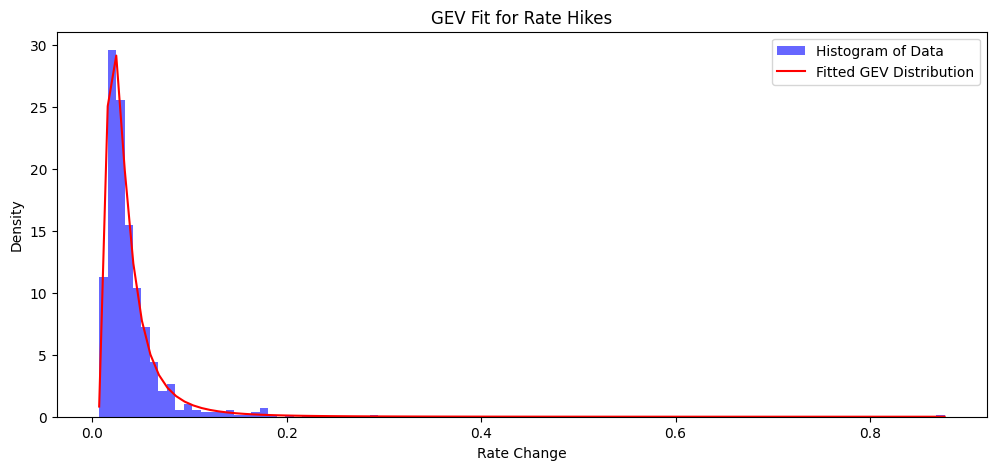

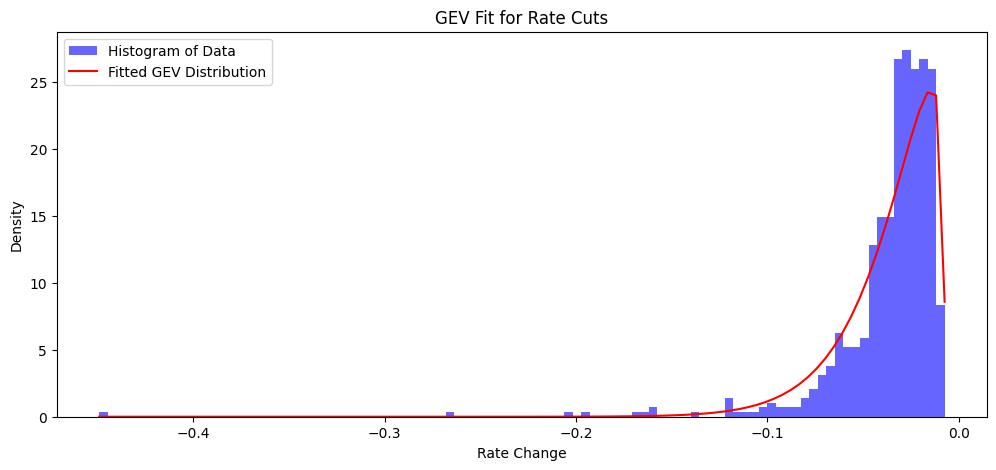

In [414]:
# Visualizing the Fitted GEV Distribution
def plot_gev_fits(data, gev_params, title):
    plt.figure(figsize=(12, 5))
    x = np.linspace(min(data), max(data), 100)
    pdf = genextreme.pdf(x, *gev_params)
    plt.hist(data, bins=len(x), density=True, alpha=0.6, color='b', label='Histogram of Data')
    plt.plot(x, pdf, 'r-', label='Fitted GEV Distribution')
    plt.title(title)
    plt.xlabel('Rate Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_gev_fits(block_maxima_hikes, gev_params_hikes, 'GEV Fit for Rate Hikes')
plot_gev_fits(block_minima_cuts, gev_params_cuts, 'GEV Fit for Rate Cuts')

In [415]:
# Peak Over Threshold (POT) Method
threshold_pos = df['rate_change'].quantile(0.95)
extreme_hikes = df[df['rate_change'] > threshold_pos]['rate_change']
gpd_params_hikes = genpareto.fit(extreme_hikes)
print("GPD Parameters (Hikes - Shape, Location, Scale):", gpd_params_hikes)

threshold_neg = df['rate_change'].quantile(0.05)
extreme_cuts = df[df['rate_change'] < threshold_neg]['rate_change']
gpd_params_cuts = genpareto.fit(extreme_cuts)
print("GPD Parameters (Cuts - Shape, Location, Scale):", gpd_params_cuts)

GPD Parameters (Hikes - Shape, Location, Scale): (np.float64(0.5499058523308382), np.float64(0.0305242200145263), np.float64(0.012995164017403266))
GPD Parameters (Cuts - Shape, Location, Scale): (np.float64(-2.810898803825795), np.float64(-0.45008314262692667), np.float64(1.1806905636837688))


In [416]:
# Compute 95% Value-at-Risk (VaR) and Expected Shortfall (ES)
var_95_hikes = genextreme.ppf(0.95, *gev_params_hikes)
es_95_hikes = np.mean(block_maxima_hikes[block_maxima_hikes >= var_95_hikes])

var_95_cuts = genextreme.ppf(0.01, *gev_params_cuts)
es_95_cuts = np.mean(block_minima_cuts[block_minima_cuts <= var_95_cuts])

print(f"95% VaR (Hikes): {var_95_hikes}")
print(f"95% Expected Shortfall (Hikes): {es_95_hikes}")
print(f"95% VaR (Cuts): {var_95_cuts}")
print(f"95% Expected Shortfall (Cuts): {es_95_cuts}")

95% VaR (Hikes): 0.09390339795273225
95% Expected Shortfall (Hikes): 0.17010353410364953
95% VaR (Cuts): -0.11743289659780479
95% Expected Shortfall (Cuts): -0.18321907379181168
